In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils

In [2]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/sust_var_jan_BC/OutputDir/GEOSChem.AerosolMass.201601*', combine = 'by_coords')

In [3]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/base_2016_jan_BC/OutputDir/GEOSChem.AerosolMass.201601*', combine = 'by_coords')

In [4]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/base_2016_jan_BC/OutputDir/HEMCO_diagnostics.201601*', combine = 'by_coords')

In [5]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/sust_var_jan_BC/OutputDir/HEMCO_diagnostics.201601*.nc', combine = 'by_coords')

In [6]:
ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_2x/2x_jan_BC/OutputDir/GEOSChem.AerosolMass.201601*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_2x/2x_jan_BC/OutputDir/HEMCO_diagnostics.201601*', combine = 'by_coords')

In [7]:
height = pd.read_excel('gc_altitude.xlsx')

In [8]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [9]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [10]:
sec_day = 86400

In [11]:
datasets = [ds_emispulse, ds_emisbase, ds_base, ds_delta, ds_conc2x, ds_emis2x]

In [12]:
for ds in [ds_emispulse, ds_emisbase,ds_emis2x]:
    utils.combine_BC(ds)

## Recreate Doubled Concentration

In [13]:
def global_w_mean(ds, variable):
    return (ds[variable].weighted(ds['AREA']*ds['dz']).mean(dim = ['lat','lon','lev']))

In [14]:
def global_sfc_w_mean(ds, variable):
    return (ds[variable].isel(lev = 0).weighted(ds['AREA']*ds['dz'].isel(lev = 0)).mean(dim = ['lat','lon']))

In [15]:
def lev_mean(ds, variable):
    return (ds[variable].weighted(ds['AREA']*ds['dz']).mean(dim = ['lev']))

In [17]:
#lev 1
f = (global_w_mean(ds_emis2x, 'EmisBC_Total') - global_w_mean(ds_emisbase, 'EmisBC_Total'))
f= f.assign_coords(time = np.arange(0,len(f['time'])))
G = (global_sfc_w_mean(ds_delta,'AerMassBC')-global_sfc_w_mean(ds_base,'AerMassBC'))
G = G.assign_coords(time = np.arange(0,len(G['time'])))

f0 = (global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      global_w_mean(ds_emisbase, 'EmisBC_Total'))
f0 = f0.assign_coords(time = np.arange(0,len(f0['time'])))


In [30]:
ds_emis2x['EmisBC_Total']

<xarray.DataArray 'EmisBC_Total' (time: 31, lev: 34, lat: 46, lon: 72)>
dask.array<mul, shape=(31, 34, 46, 72), dtype=float64, chunksize=(1, 34, 46, 72), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.9925 0.9775 0.9625 ... 0.001134 0.0001387 3.8e-05
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -89.0 -86.0 -82.0 -78.0 -74.0 ... 78.0 82.0 86.0 89.0
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-01-31
Attributes:
    full_name:  total black carbon
    units:      kg/m2/day

```python
f = [1,2,3]
G = [1, 0.5, 0.25, 0.01]

plt.plot([t[0], t[1], t[2]], [f[0]*G[i].values*dt for i in [0, 1, 2]])
plt.plot([t[0], t[1], t[2]], [f[0]*G[i+1].values*dt for i in [0, 1, 2]] + [f[1]*G[i].values*dt for i in [0, 1, 2]])  
```

In [21]:
Ndt = 10
dt = 1 #days
t_range = np.arange(0., dt*Ndt, dt)
Δt = 1


In [22]:
C_ds = xr.Dataset(
    data_vars = dict(c = (["tp","lev","lat","lon","time"], np.zeros([len(t_range),len(ds_base['lev']),len(ds_base['lat']),len(ds_base['lon']),len(f['time'])]))),
    coords = dict(
        tp = t_range,
        lev = ("lev", ds_base['lev']),
        lat = ("lat", ds_base['lat']),
        lon = ("lon", ds_base['lon']),
        time = f['time']
    )

)

###  need to fix the t and i ordering here

In [23]:
for i, tp in enumerate(t_range):
    for t in t_range:
        C_ds['c'].loc[dict(tp = tp, time = t)] = utils.G_f_kernel(G, f, t, tp,Δt, dt, f0)
        


In [24]:
C_df = C_ds.isel(lev = 0).sel(lat = 50, lon = -100, method = 'nearest').drop(['lat','lon','lev']).to_dataframe().unstack()

#testing for just a dataframe (not spatially explicit, use for lev 1)
C_df = pd.DataFrame(columns = np.arange(0, len(t_range)), index = t_range)

for i, tp in enumerate(t_range):
    for t in t_range:
        i = int(i)
        C_df[i].loc[t] = utils.G_f_kernel(G, f, t, tp,Δt, dt, f0,ds_output = False)
        


In [25]:
len(np.arange(0,len(ds_base['time'])-1))

31

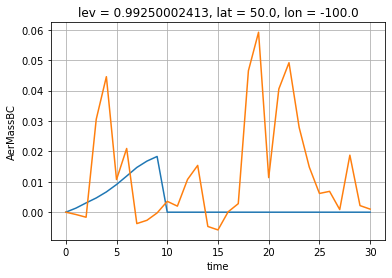

In [26]:
C_df.sum(axis = 1).plot()
(ds_conc2x['AerMassBC'].sel(lat = 50, lon = -100, method = 'nearest') - ds_base['AerMassBC'].sel(lat = 50, lon = -100, method = 'nearest')).isel(lev = 0)[1:].assign_coords(time = np.arange(0,len(ds_base['time']) -1)).plot()
plt.grid()

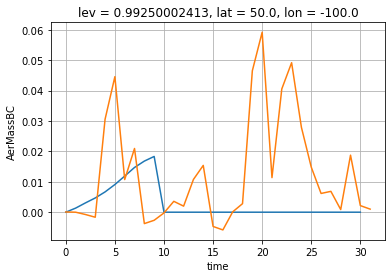

In [27]:
C_df.sum(axis = 1).plot()
(ds_conc2x['AerMassBC'].sel(lat = 50, lon = -100, method = 'nearest') - ds_base['AerMassBC'].sel(lat = 50, lon = -100, method = 'nearest')).isel(lev = 0).assign_coords(time = np.arange(0,len(ds_base['time']))).plot()
plt.grid()

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/em

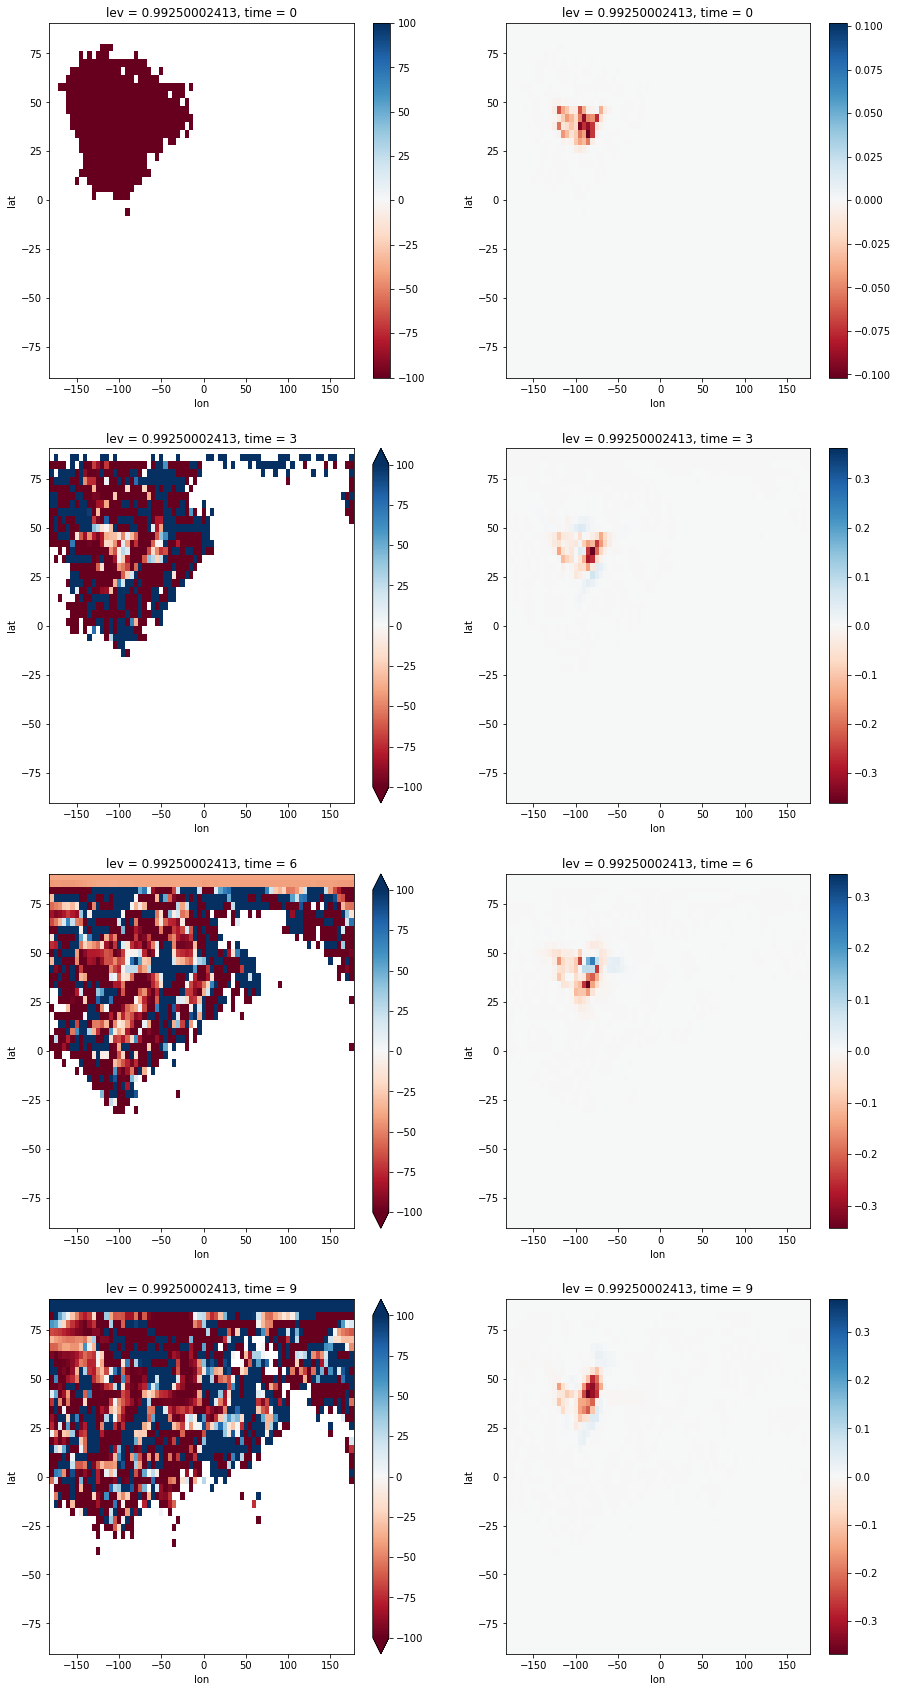

In [92]:
fig, axes = plt.subplots(4,2, figsize = [15,30])
for idx, t in enumerate([0,3,6,9]):
    lev = 0
    vmin = 0
    vmax = .05
    (((C_ds.sum(dim = 'tp').isel(lev = lev, time = t)['c'] - 
     ((ds_conc2x['AerMassBC']-ds_base['AerMassBC']).isel(lev = lev)).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = t))/
     ((ds_conc2x['AerMassBC']-ds_base['AerMassBC']).isel(lev = lev)).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = t))*100).plot(ax = axes[idx,0], vmax = 100, vmin = -100, cmap = 'RdBu')
    
    ((C_ds.sum(dim = 'tp').isel(lev = lev, time = t)['c'] - 
     ((ds_conc2x['AerMassBC']-ds_base['AerMassBC']).isel(lev = lev)).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = t))).plot(ax = axes[idx,1], cmap = 'RdBu')
    

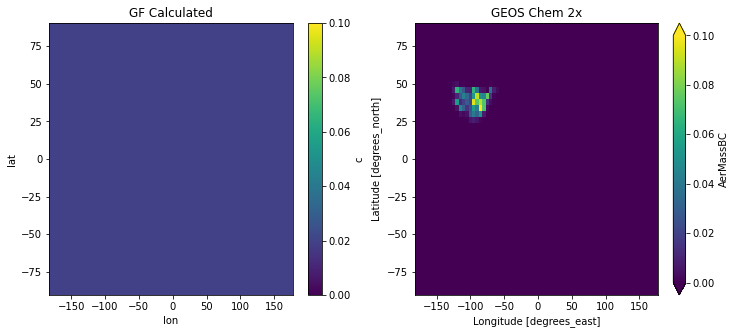

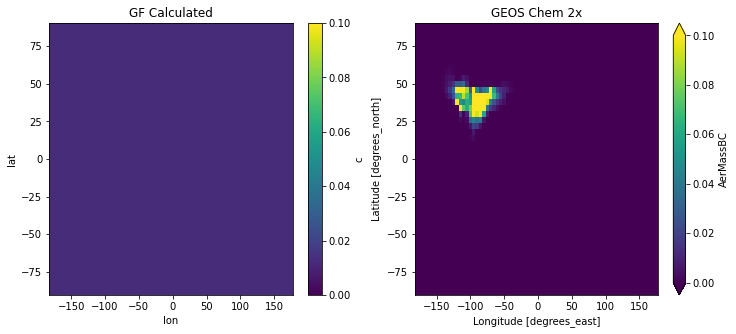

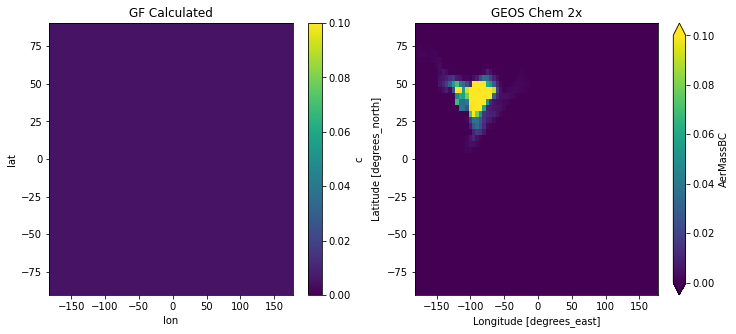

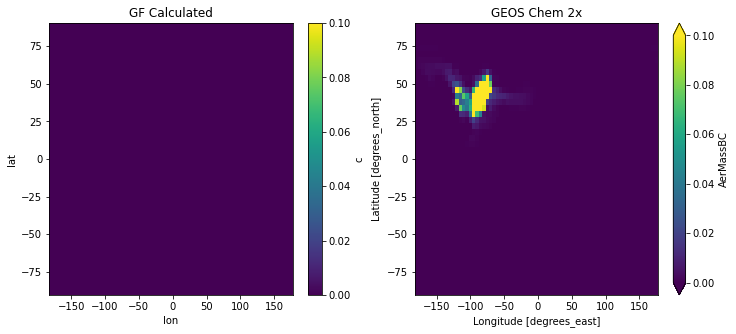

In [32]:
for t in [0,3,6,9]:

    fig, axes = plt.subplots(ncols = 2, figsize = [12,5])
    vmin = 0
    vmax = .1
    C_ds.sum(dim = 'time').isel(lev = 0, tp = t)['c'].plot(ax = axes[0],
                                                vmin = vmin,
                                                vmax = vmax)
    axes[0].set_title('GF Calculated')
    ((ds_conc2x['AerMassBC']-ds_base['AerMassBC']).isel(lev = 0)).assign_coords(time = np.arange(0,len(ds_base['time']))).isel(time = t).plot(
        ax = axes[1],
        vmin = vmin,
        vmax = vmax)
    axes[1].set_title('GEOS Chem 2x')
